In [202]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 5)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def remove_noise(binary_image):
    ret_val = erode(erode(dilate(binary_image)))
    ret_val = invert(ret_val)
    return ret_val


In [203]:
def select_roi(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_dict = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        if area > 40 and h < 100 and h > 5 and w > 5:
            region = image_bin[y:y+h+1,x:x+w+1];
            # Proširiti regions_dict elemente sa vrednostima boundingRect-a ili samim konturama
            regions_dict[y] = [resize_region(region),(x,y,w,h)]
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += y
        region_distances.append(-y-h)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

In [204]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=10,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [220]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (idx==3):
            result+= ' '
        if (idx==9):
            result+= ' '    
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

In [206]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=24,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

Broj prepoznatih regiona: 24


KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

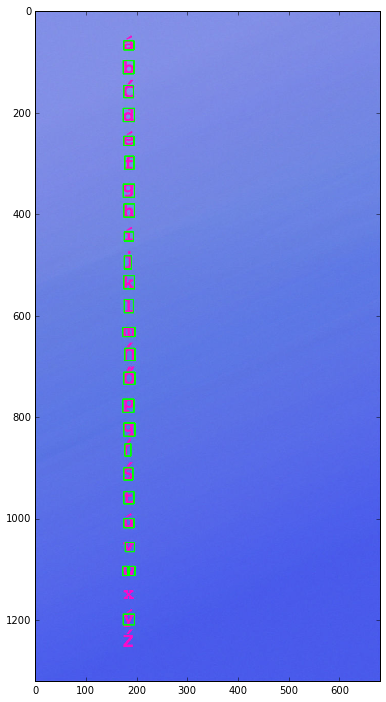

In [207]:
train=cv2.imread('fifi_train.jpg')
train=cv2.cvtColor(train,cv2.COLOR_RGB2BGR)

visina,sirina = train.shape[0:2]
image_gray= np.ndarray((visina, sirina), dtype=np.uint8)

for i in range(0,visina):
    for j in range(0,sirina):
        pixel=train[i,j]
        r,g,b=pixel[0],pixel[1],pixel[2]
        gray = float(r) * .2989 + float(g) * .997 + float(b) * .114 # racunanje grayscale intenziteta
        image_gray[i, j] = gray # postavljanje piksela na rezultujucoj slici

train_bin=image_bin_adaptive(image_gray)
train_bin=invert(train_bin)
train_bin=dilate(erode(train_bin))
display_image(train_bin)

selected_regions, numbers, distances = select_roi(train.copy(), train_bin)
display_image(selected_regions)
print 'Broj prepoznatih regiona:', len(numbers)

distances = np.array(distances).reshape(len(distances), 1)
#Neophodno je da u K-means algoritam bude prosleđena matrica u kojoj vrste određuju elemente

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(distances)


In [208]:
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','y']
inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [210]:
result = ann.predict(np.array(inputs, np.float32))
print display_result(result, alphabet,k_means)

a b c d e f g h i j k l m n o p q r s t u v wy


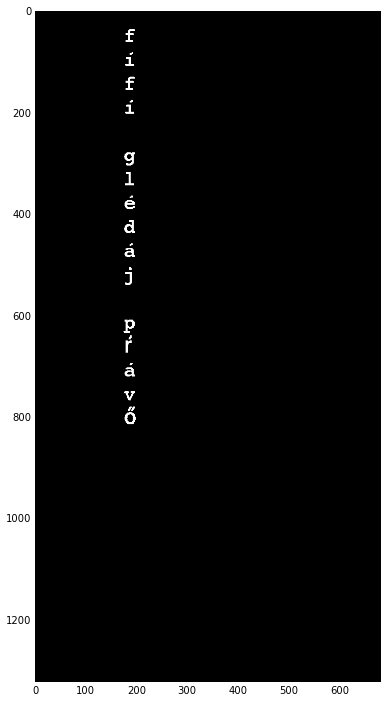

In [211]:
test=cv2.imread('fifi_test.jpg')
test=cv2.cvtColor(test,cv2.COLOR_RGB2BGR)

visina,sirina = test.shape[0:2]
image_gray= np.ndarray((visina, sirina), dtype=np.uint8)

for i in range(0,visina):
    for j in range(0,sirina):
        pixel=test[i,j]
        r,g,b=pixel[0],pixel[1],pixel[2]
        gray = float(r) * .2989 + float(g) * .897 + float(b) * .214 # racunanje grayscale intenziteta
        image_gray[i, j] = gray # postavljanje piksela na rezultujucoj slici

test_bin=image_bin_adaptive(image_gray)
test_bin=invert(test_bin)
test_bin=dilate(erode((test_bin)))
#test_bin=erode(test_bin)
display_image(test_bin)


Broj prepoznatih regiona: 15


KMeans(copy_x=True, init='k-means++', max_iter=2000, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=1e-05,
    verbose=0)

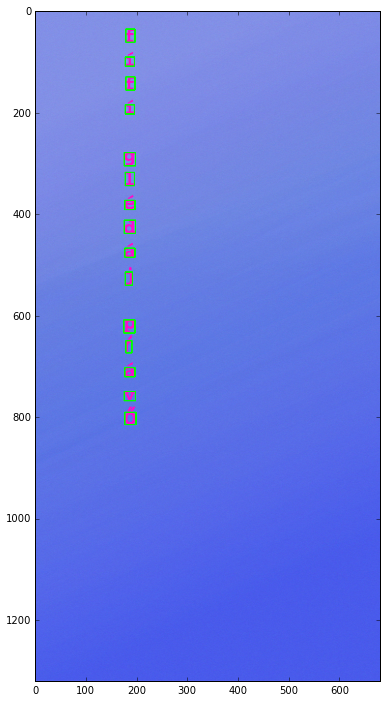

In [212]:
selected_regions, numbers, distances = select_roi(test.copy(), test_bin)
display_image(selected_regions)
print 'Broj prepoznatih regiona:', len(numbers)

#Podešavanje centara grupa K-means algoritmom
distances = np.array(distances).reshape(len(distances), 1)
#Neophodno je da u K-means algoritam bude prosleđena matrica u kojoj vrste određuju elemente

k_means = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means.fit(distances)

In [221]:
inputs = prepare_for_ann(numbers)
results = ann.predict(np.array(inputs, np.float32))
print display_result(results, alphabet,k_means)

f i f i  g l e d a j  p r a yo
